In [2]:
# taken from:
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
# https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
import os
import pandas as pd
import numpy as np
from skimage import io, transform
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split

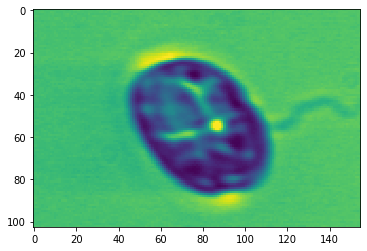

In [24]:
## helper functions

data_folder = "./data"

# get all labels and file names
def get_lbls_fnames(years, ignored_classes=[]):
    fnames = []
    labels = []
    for year in years:
        year_path = data_folder+"/"+year
        if os.path.isdir(year_path):
            for class_name in os.listdir(year_path):
                if class_name in ignored_classes:
                    continue
                c_path = year_path + "/"+class_name

                if os.path.isdir(c_path):
                    image_files = [x for x in os.listdir(c_path) if ".png" in x]
                    fnames.extend(image_files)
                    labels.extend([class_name]*len(image_files))
    return fnames, labels

# split into train,test or train,val,test
def data_split(X, Y, pc_splits):
    xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size = pc_splits[-1])
    if len(pc_splits) == 3:
        xTrain, xVal, yTrain, yVal = train_test_split(xTrain, yTrain, test_size = pc_splits[1]/(pc_splits[0]+pc_splits[1]))
        return (xTrain, yTrain, xVal, yVal, xTest, yTest)
    return (xTrain, yTrain, xTest, yTest)
    
    
    
# to show image
def show_plankton(image, size):
    plt.imshow(image.reshape(size))
    plt.pause(0.001)  # pause a bit so that plots are updated

    
    
# image transformations
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image':img, 'label':sample['label']}

# for data augmentation
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h) 
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return {'image':image, 'label':sample['label']}

# to convert numpy images to torch images
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((0, 1))
        return {'image':torch.from_numpy(image), 'label':sample['label']}

plt.figure()

img_names = np.array(os.listdir('data/2006/Karenia'))
img = io.imread(os.path.join('data/2006/Karenia', img_names[0]))
show_plankton(img, img.shape)
plt.show()

In [28]:
years = [str(i) for i in range(2006, 2007)]
fnames, lbls = get_lbls_fnames(years)

x = data_split(fnames, lbls, [0.6,0.2, 0.2])
print(x[3])

['mix', 'mix', 'mix', 'mix', 'Leptocylindrus', 'Leptocylindrus', 'mix', 'mix', 'mix', 'mix', 'mix', 'mix', 'mix', 'Leptocylindrus', 'mix', 'Leptocylindrus', 'mix', 'Pleurosigma', 'mix', 'mix', 'Leptocylindrus', 'Strombidium_inclinatum', 'mix', 'detritus', 'mix', 'Leptocylindrus', 'mix', 'mix', 'detritus', 'mix', 'mix', 'mix', 'mix_elongated', 'mix', 'detritus', 'mix', 'mix', 'Pseudonitzschia', 'mix', 'mix', 'mix', 'mix', 'bead', 'Leptocylindrus', 'mix', 'Leptocylindrus', 'mix', 'detritus', 'mix', 'Thalassionema', 'detritus', 'Chrysochromulina', 'Chaetoceros', 'mix', 'mix', 'detritus', 'mix', 'mix', 'detritus', 'mix', 'mix', 'mix', 'mix', 'mix', 'mix', 'mix', 'mix', 'mix', 'detritus', 'mix', 'dino30', 'mix', 'mix', 'Leptocylindrus', 'mix', 'mix', 'DactFragCerataul', 'mix', 'mix', 'mix', 'mix', 'Dictyocha', 'mix', 'mix', 'mix', 'mix', 'mix', 'mix', 'mix', 'mix', 'mix', 'mix', 'detritus', 'Guinardia_delicatula', 'mix', 'mix', 'Guinardia_delicatula', 'mix', 'Guinardia_delicatula', 'mix', '

In [9]:
#dataset class
from numpy import array
from sklearn.preprocessing import LabelEncoder


class PlanktonDataset(Dataset):
    
    def _oneHotEncoding(self, labels):
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(labels)
        n = np.max(integer_encoded)
        
        return torch.nn.functional.one_hot(torch.from_numpy(integer_encoded), int(n)+1)
    
    def __init__(self, ids, labels, root_dir, transform=None):
        self.root_dir = root_dir
        self.file_ids = ids
        self.file_labels = labels
        self.encoded_labels = self._oneHotEncoding(labels)
        self.transform = transform
    
    def __len__(self):
        return len(self.file_ids)

    def __getitem__(self, index):
        file_name = self.file_ids[index]
        year = file_name.split("_")[1]
        label = self.file_labels[index] 
        encoded_label = self.encoded_labels[index]
        
        img_name = os.path.join(self.root_dir, year, label, file_name)
        img = io.imread(img_name)

        sample = {'image': img, 'label': label}
        
        if self.transform:
            sample = self.transform(sample)
            
        sample['encoded_label'] = encoded_label
        sample['image'] = sample['image'].reshape((1,sample['image'].shape[0], sample['image'].shape[1]))
        
        return sample

{'image': tensor([[[0.8073, 0.8069, 0.8079,  ..., 0.8208, 0.8197, 0.8202],
         [0.8077, 0.8077, 0.8079,  ..., 0.8184, 0.8169, 0.8175],
         [0.8071, 0.8065, 0.8079,  ..., 0.8220, 0.8211, 0.8215],
         ...,
         [0.8304, 0.8316, 0.8288,  ..., 0.8262, 0.8285, 0.8275],
         [0.8350, 0.8369, 0.8324,  ..., 0.8255, 0.8272, 0.8265],
         [0.8319, 0.8334, 0.8300,  ..., 0.8260, 0.8281, 0.8272]]],
       dtype=torch.float64), 'label': 'mix', 'encoded_label': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0])}
0 torch.Size([1, 120, 255]) mix


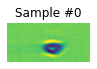

{'image': tensor([[[0.8047, 0.8049, 0.8044,  ..., 0.8358, 0.8373, 0.8366],
         [0.8044, 0.8045, 0.8042,  ..., 0.8371, 0.8393, 0.8384],
         [0.8056, 0.8060, 0.8050,  ..., 0.8322, 0.8315, 0.8318],
         ...,
         [0.8121, 0.8124, 0.8118,  ..., 0.8271, 0.8268, 0.8270],
         [0.8082, 0.8087, 0.8074,  ..., 0.8201, 0.8212, 0.8207],
         [0.8092, 0.8097, 0.8085,  ..., 0.8220, 0.8227, 0.8224]]],
       dtype=torch.float64), 'label': 'mix', 'encoded_label': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0])}
1 torch.Size([1, 120, 255]) mix


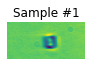

{'image': tensor([[[0.7777, 0.7771, 0.7824,  ..., 0.7825, 0.7830, 0.7829],
         [0.7764, 0.7759, 0.7805,  ..., 0.7832, 0.7835, 0.7835],
         [0.7812, 0.7805, 0.7875,  ..., 0.7803, 0.7814, 0.7813],
         ...,
         [0.7666, 0.7664, 0.7687,  ..., 0.7841, 0.7826, 0.7828],
         [0.7773, 0.7777, 0.7742,  ..., 0.7823, 0.7833, 0.7831],
         [0.7745, 0.7747, 0.7727,  ..., 0.7828, 0.7831, 0.7831]]],
       dtype=torch.float64), 'label': 'mix', 'encoded_label': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0])}
2 torch.Size([1, 120, 255]) mix


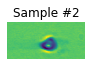

{'image': tensor([[[0.8453, 0.8477, 0.8494,  ..., 0.8680, 0.8628, 0.8609],
         [0.8432, 0.8451, 0.8481,  ..., 0.8661, 0.8608, 0.8595],
         [0.8358, 0.8359, 0.8437,  ..., 0.8596, 0.8540, 0.8544],
         ...,
         [0.8353, 0.8373, 0.8386,  ..., 0.8697, 0.8686, 0.8633],
         [0.8348, 0.8306, 0.8344,  ..., 0.8610, 0.8603, 0.8601],
         [0.8346, 0.8287, 0.8332,  ..., 0.8585, 0.8579, 0.8592]]],
       dtype=torch.float64), 'label': 'Dactyliosolen', 'encoded_label': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}
3 torch.Size([1, 120, 255]) Dactyliosolen


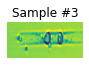

In [10]:
years = [str(i) for i in range(2006, 2007)]
fnames, lbls = get_lbls_fnames(years)

train_fnames, train_lbls, test_fnames, test_lbls = data_split(fnames, lbls, [0.6,0.4])

train_dataset = PlanktonDataset(train_fnames, train_lbls, './data', 
                                transform=transforms.Compose([
                                               Rescale((120, 255)),
                                               ToTensor()
                                           ]))

test_dataset = PlanktonDataset(test_fnames, test_lbls, './data', 
                                transform=transforms.Compose([
                                               Rescale((120, 255)),
                                               ToTensor()
                                           ]))

fig = plt.figure()

for i in range(len(train_dataset)):
    sample = train_dataset[i]

    print(sample)
    print(i, sample['image'].shape, sample['label'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_plankton(sample['image'], (sample['image'].shape[1], sample['image'].shape[2]))

    if i == 3:
        plt.show()
        break
        
        

In [5]:
"""
# using CUDA
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device("cuda:0" if use_cuda else "cpu")
cudnn.benchmark = True
"""

'\n# using CUDA\n# CUDA for PyTorch\nuse_cuda = torch.cuda.is_available()\nprint(use_cuda)\ndevice = torch.device("cuda:0" if use_cuda else "cpu")\ncudnn.benchmark = True\n'

In [3]:
# so we have the dataset, now the CNN LOL. taken from: simple_CNN
#Define a CNN

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 27 * 60, 120) # 27 * 60 from image dimension, see implementation doc for details
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 88) # 87 because some classes have no images

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 27 * 60)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

#define the loss function and optimizer
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

print(net)


Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=25920, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=88, bias=True)
)


In [11]:
#train the network
trainloader = DataLoader(train_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

net = net.float()

for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        #get the unputs; data is a list of [inputs, labels]
        inputs, labels = data['image'], data['encoded_label'].float()
        
        
        #zero the param gradients
        optimizer.zero_grad()
        
        #forward + backward + optimize
        outputs = net(inputs.float())
        
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i+1, running_loss/2000))
            running_loss = 0.0
            
print('Finished Training')


[1,  2000] loss: 0.007
[1,  4000] loss: 0.006


KeyboardInterrupt: 

In [7]:
# saving model
version = 1.0
path_to_statedict = './models/first_CNN-'+str(version)+'.pth' 


# Print model's state_dict
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

torch.save(net.state_dict(), path_to_statedict)


Model's state_dict:
conv1.weight 	 torch.Size([6, 1, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 25920])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([88, 84])
fc3.bias 	 torch.Size([88])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.01, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [120886821800, 120886821872, 120886821728, 120886821944, 120886822016, 120886822088, 120886822160, 120886822232, 120886822304, 120886822376]}]


In [11]:
model = Net()
model.load_state_dict(torch.load(path_to_statedict))
model.eval()


Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=25920, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=88, bias=True)
)

In [23]:
# loading
dataiter = iter(trainloader)
sample = dataiter.next()
images, labels = sample['image'], sample['label']



tensor([[ 0.0621, -0.0632, -0.0135,  0.0405,  0.0231, -0.0328, -0.0675, -0.0394,
          0.0306, -0.0713,  0.0956, -0.0218,  0.0421,  0.0709,  0.0628,  0.0226,
         -0.0109, -0.0285, -0.0831, -0.1162, -0.0475, -0.0024,  0.0857, -0.0210,
         -0.0629,  0.1521, -0.1133, -0.0947, -0.0632, -0.0051, -0.1256, -0.0631,
         -0.0040, -0.1002,  0.0594,  0.0506,  0.0983,  0.0676, -0.0346, -0.1237,
         -0.0819,  0.0654,  0.0381,  0.0024, -0.0646, -0.0671,  0.0256,  0.0507,
          0.0599,  0.0396, -0.0786, -0.0184, -0.1164, -0.0110, -0.0971,  0.0571,
          0.0170, -0.0420, -0.0304, -0.0642, -0.0438, -0.0653, -0.0301, -0.0874,
         -0.0080, -0.1248, -0.0847,  0.0393,  0.0713,  0.0882, -0.0014, -0.0093,
          0.0457, -0.0413,  0.0363,  0.0822,  0.0041,  0.0396, -0.0983, -0.1116,
         -0.0844, -0.0912,  0.0802, -0.0180,  0.0483,  0.1148, -0.0819,  0.1028],
        [ 0.0643, -0.0621, -0.0127,  0.0398,  0.0209, -0.0323, -0.0709, -0.0389,
          0.0315, -0.0723, 

In [ ]:
# saving and loading checkpoints. so do this on every epoch? or lets see. have a hyperparameter for this
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            ...
            }, PATH)

model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
# - or -
model.train()